## Import Relevant Systems 

In [112]:
%matplotlib inline

import os 
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import contextily as cx


## Import data

In [113]:
substations = gpd.read_file(os.path.abspath('Data/belfastSubstations.shp')) # Import Substations data from Data folder within Repository
EVcharging = gpd.read_file(os.path.abspath('Data/evChargingStations_belfast.shp')) # Import EV Charging data from same folder

## Check CRS

In [51]:
substations.crs # Confirm the CRS for the substation layer
EVcharging.crs # Confirm the CRS for the EV Charging layer

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Reproject Data from Geographic CRS to Projected CRS for buffering and cooperation with basemap

In [114]:
substations_wm = substations.to_crs(epsg=3857) # Convert to Web Mercator
EVcharging_wm = EVcharging.to_crs(epsg=3857) # Convert to Web Mercator

## Examine Substation Data

In [6]:
substations.head(10) # Examine the attribute table associated with the substation data

,dataset,license_ar,site_name,site_funct,site_type,site_volta,site_stree,site_town_,site_count,site_postc,site_longi,site_latit,lad_name,lad_code,geometry
0,Primary Substations,NIE Networks,BALLYMACARRETT,10000618,PRIMARY,33KV,None,BELFAST,ANTRIM,BT5 5BB,336614.230374,374087.387280,Belfast,N09000003,POINT (-5.88703 54.59655)
1,Primary Substations,NIE Networks,BALLYSILLAN,10000625,PRIMARY,33KV,108 ALLIANCE RD,BELFAST,ANTRIM,BT14 7JF,331616.243565,376578.967095,Belfast,N09000003,POINT (-5.96319 54.62025)
2,Primary Substations,NIE Networks,BALMORAL,10000626,PRIMARY,33KV,None,BELFAST,ANTRIM,BT10 0HB,330798.657759,370428.930084,Belfast,N09000003,POINT (-5.97857 54.56525)
3,Primary Substations,NIE Networks,CITY HOSPITAL S/D,10370529,PRIMARY,33KV,37 LISBURN ROAD,BELFAST,ANTRIM,None,333306.445984,372967.550692,Belfast,N09000003,POINT (-5.93868 54.58738)
4,Primary Substations,NIE Networks,LAGANSIDE,10000891,PRIMARY,33KV,None,BELFAST,ANTRIM,None,334650.990502,374032.514494,Belfast,N09000003,POINT (-5.91741 54.59659)
5,Primary Substations,NIE Networks,MULHOUSE ROAD,10481081,PRIMARY,33KV,MULHOUSE ROAD,BELFAST,ANTRIM,BT12,332495.322170,373583.653645,Belfast,N09000003,POINT (-5.95094 54.59313)
6,Primary Substations,NIE Networks,SHANKILL,10000773,PRIMARY,33KV,None,BELFAST,ANTRIM,BT13 1RP,332313.465192,375322.299851,Belfast,N09000003,POINT (-5.95297 54.60878)
7,Primary Substations,NIE Networks,AIRPORT ROAD,10000604,PRIMARY,33KV,AIRPORT ROAD,BELFAST,ANTRIM,None,335851.146849,374880.534631,Belfast,N09000003,POINT (-5.89846 54.60388)
8,Primary Substations,NIE Networks,BELFAST HARBOUR COMMISSIONERS (HVC),10480856,PRIMARY,33KV,None,BELFAST,ANTRIM,None,336800.074259,377074.701999,Belfast,N09000003,POINT (-5.88276 54.62332)
9,Primary Substations,NIE Networks,BOG MEADOWS,10000637,PRIMARY,33KV,BOG MEADOWS,BELFAST,ANTRIM,BT12 6HR,331560.016525,371505.096866,Belfast,N09000003,POINT (-5.96633 54.57471)


## Create 200m Buffer around Substations

In [116]:
buffer = substations_wm.buffer(200) # Create a 200m buffer around the Belfast Substations
buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs="EPSG:3857") # Convert the GeoSeries into a GeoDataFrame in Web Mercator
buffer_gdf.head() # Show the first 5 records within the newly created GeoDataFrame

,geometry
0,"POLYGON ((-655140.927 7283955.987, -655141.89 ..."
1,"POLYGON ((-663618.734 7288509.934, -663619.697..."
2,"POLYGON ((-665331.483 7277942.59, -665332.446 ..."
3,"POLYGON ((-660890.514 7282194.005, -660891.477..."
4,"POLYGON ((-658522.626 7283962.461, -658523.589..."


## Create reference system to project data

In [117]:
map_crs = ccrs.Mercator() # Create a standard coordinate system for the map figure. 

## Check Extent of Data

In [70]:
print(buffer_gdf.total_bounds) # Check total extents for map extent

[-670046.09894093 7276411.75366261 -653093.87416041 7290820.24148441]


## Create Figure

(7276411.7536626095, 7290820.24148441)

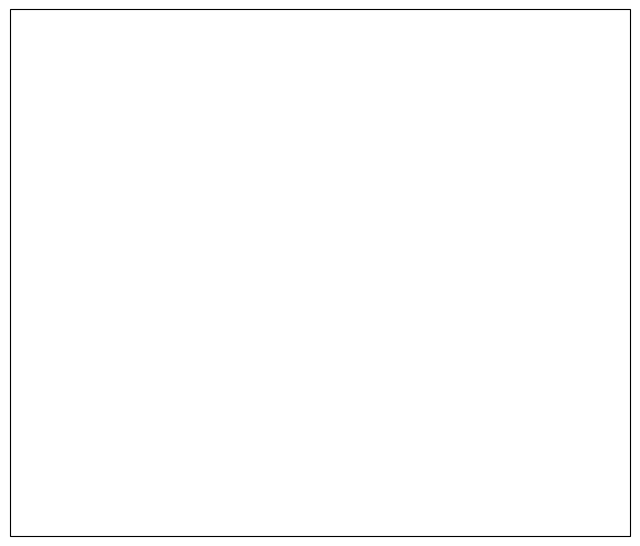

In [119]:
fig = plt.figure(figsize=(8, 8))  # create a figure of size 8x8 inches
ax = plt.axes(projection=map_crs)  # creates axis in EPSG 3857
ax.set_xlim(buffer_gdf.total_bounds[[0, 2]]) # Set map extent to match total bounds of buffer feature
ax.set_ylim(buffer_gdf.total_bounds[[1, 3]])

## Create Scale Bar using a predefined function

In [120]:
def scale_bar(ax, length=1, location=(0.92, 0.95)): # Axel location within figure
    x0, x1, y0, y1 = ax.get_extent() # get the current extent of the axis
    sbx = x0 + (x1 - x0) * location[0] #  Correct x coordinate of the scale bar
    sby = y0 + (y1 - y0) * location[1] # Correct y coordinate of the scale bar

    ax.plot([sbx, sbx-length*1000], [sby, sby], color='k', linewidth=4, transform=ax.projection) # Plot a thick black line
    ax.plot([sbx-(length/2)*1000, sbx-length*1000], [sby, sby], color='w', linewidth=2, transform=ax.projection) # Plot a white line to halfway mark

    ax.text(sbx, sby-(length/4)*1000, f"{length} km", ha='center', transform=ax.projection, fontsize=6) # Add right hand label
    ax.text(sbx-(length/2)*1000, sby-(length/4)*1000, f"{int(length/2)} km", ha='center', transform=ax.projection, fontsize=6) # Add middle label
    ax.text(sbx-length*1000, sby-(length/4)*1000, '0 km', ha='center', transform=ax.projection, fontsize=6) # Add left hand label

    return ax

# Adopted from Mapping with Cartopy Exercise within https://github.com/iamdonovan

## Create Legend Patches

In [121]:
def map_legend(ax):
    buffer_patch = mpatches.Patch(color="lightsalmon", label="200m Buffer") # Add patch to legend for Buffer polygon data
    substations_marker = mlines.Line2D([], [], color="dodgerblue", marker="s", linestyle="None", markersize=7, label="NIE Substations") # Add patch to legend for Substation point data
    charging_marker = mlines.Line2D([], [], color="limegreen", marker="o", linestyle="None", markersize=7, label="EV Charging Points") # Add patch to legend for EV Charger point data

    ax.legend(handles=[buffer_patch, substations_marker, charging_marker], loc="lower left", fontsize=8, frameon=True)

## Add Data to the Map

In [134]:
#Add Basemap 
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik) # Add basemap to figure using Contexitly 

#Add Buffer
buffer_feature = ShapelyFeature(buffer_gdf['geometry'], map_crs, edgecolor="lightsalmon", facecolor="lightsalmon")  # Create a map feature for the buffers and add symbology                              
ax.add_feature(buffer_feature) # Add buffers to map

# Add Substations
substations_feature = ax.plot(substations_wm.geometry.x, substations_wm.geometry.y, 's', color="dodgerblue", ms=3, label="NIE Substations") 

# Add EV Charging Stations
EVcharging_feature = ax.plot(EVcharging_wm.geometry.x, EVcharging_wm.geometry.y, 'o', color="limegreen", ms=4, label="EV Charging Points") # Add charging stations to the map

<Figure size 640x480 with 0 Axes>

## Add Map Elements and set extent

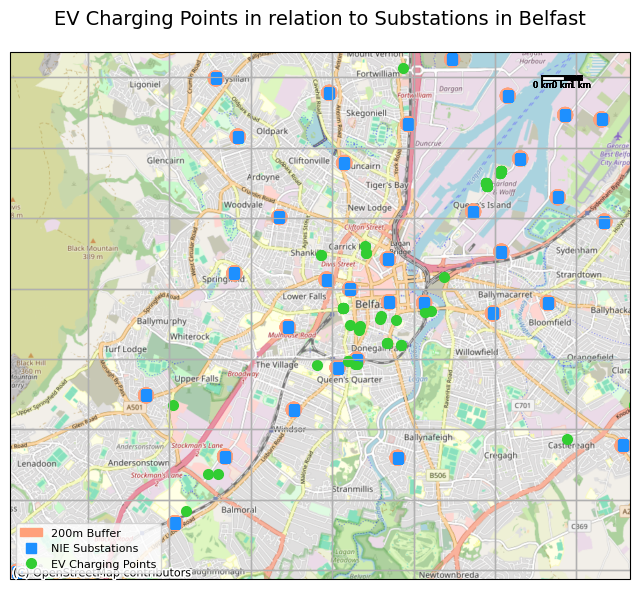

In [135]:
ax.gridlines(draw_labels=False) # Add optional gridlines to figure
scale_bar(ax) # Add scale bar
map_legend(ax) # Add legend to figure
ax.set_title("EV Charging Points in relation to Substations in Belfast", fontsize=14, pad=20) # Add a title to the figure

fig # Return Updated Figure

## Export Map

In [136]:
fig.savefig('belfastChargers.jpeg', dpi=300) # Export the map as a JPEG